In [328]:
from pathlib import Path
from typing import Union
from PIL import Image
import numpy as np
import geopandas as gpd
import geoplot as gpl
import pandas as pd
import matplotlib.pyplot as plt
import colormath.color_objects as clrobj
import colormath.color_conversions as clrcv

In [329]:
def rgb_int2tuple(rgbint):
    rgbint = int(rgbint)
    return (((rgbint >> 16) & 255)/255, ((rgbint >> 8) & 255)/255, (rgbint & 255)/255)

def rgb_tuple2int(rgbtuple):
    return int((int(255*rgbtuple[0]) << 16) + (int(255*rgbtuple[1]) << 8) + int(255*rgbtuple[2]))

def rgb_int2obj(rgbint):
    rgbint = int(rgbint)
    return clrobj.sRGBColor((rgbint >> 16) & 255, (rgbint >> 8) & 255, rgbint & 255, is_upscaled=True)

def rgb_obj2int(rgbobj):
    return int(rgbobj.get_rgb_hex(), 16)

In [330]:
def mean_not_zero(image):
    data = image.getdata()
    data = np.array(data)
    data = data[data!=255]
    return np.mean(data)

def extract_color_code(imagePath: Union[str, Path], function=mean_not_zero, base:int=16) -> str:
    from PIL import Image    
    with Image.open(Path(imagePath).absolute()).convert('RGB') as im:
        meanstring = ""
        for channel in im.getbands():
            meanstring += np.base_repr(int(function(im.getchannel(channel))), base)
        return meanstring
    
def get_colordict(image_folder_path: Union[str, Path], function=np.mean, base:int=16):
    color_dict = dict()
    for filename in Path(image_folder_path).iterdir():
        if filename.is_file():
            color_dict[filename.stem] = extract_color_code(filename)
    return color_dict

colordict = get_colordict("C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/logo")
colordict2 = {"Bezpartyjni":"000000",	"TD":"9acd32",	"Lewica":"e50000",	"PiS":"030764",	"Konfederacja":"653700",	"KO":"ffa500"}

from typing import List
def get_colormap(color_dict:dict, entry:Union[str, List[str], None], type:str="listed"):
    if type == "listed":
        from matplotlib.colors import ListedColormap
        return ListedColormap([t[1] for t in sorted(color_dict.items())])
    elif type == "linear_segmented":
        from matplotlib.colors import LinearSegmentedColormap
        return LinearSegmentedColormap.from_list(colors=['#ffffff', "#"+color_dict[entry]], name=entry+"_cmap", gamma=1)
    elif type == "linear_multi_segmented":
        from matplotlib.colors import LinearSegmentedColormap
        return LinearSegmentedColormap.from_list(colors=["#"+e.lstrip("#") for e in entry], name="linear_multi_segmented_cmap", gamma=1)
    elif type == "hex_converted":
        from matplotlib.colors import ListedColormap
        return ListedColormap(colors=[rgb_int2tuple(num) for num in range(int('ffffff', 16)+1)], name="hexRGB")
    else:
        raise KeyError("Colormap type not found!")

In [331]:
def get_weighted_color_value(colors, weights):
    colors_RGBobj = np.array([rgb_int2obj(int(color, 16)) for color in colors])
    colors_LCH = np.array([clrcv.convert_color(RGB, clrobj.LCHabColor).get_value_tuple() for RGB in colors_RGBobj])

    weights = weights if isinstance(weights, np.ndarray) else np.array(weights)
    weights = weights / sum(weights.T)[:, None] if weights.ndim >1 else weights / sum(weights.T)

    weightedLCHs = weights.dot(colors_LCH)
    weightedLCHs = weightedLCHs if weightedLCHs.ndim >1 else np.array([weightedLCHs])
    colors_LCHobjs = np.array([clrobj.LCHabColor(weightedLCH[0], weightedLCH[1], weightedLCH[2]) for weightedLCH in weightedLCHs])

    return_list = np.array([clrcv.convert_color(LCH, clrobj.sRGBColor).get_upscaled_value_tuple() for LCH in colors_LCHobjs])
    return np.array([rgb_tuple2int(val) for val in return_list])

In [332]:
for partia, value in colordict.items():
    exec(f"{partia}_logo_cmap = get_colormap(color_dict=colordict, entry='{partia}', type='linear_segmented')")
for partia, value in colordict.items():
    exec(f"{partia}_poll_cmap = get_colormap(color_dict=colordict2, entry='{partia}', type='linear_segmented')")

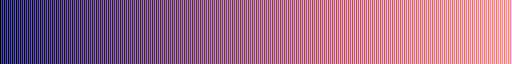

In [333]:
hex_converted_cmap = get_colormap(None, None, "hex_converted")
hex_converted_cmap

In [334]:
def parse_geography(geography_file: Union[str, Path]):
    powiaty_gpd =gpd.read_file(geography_file).set_index("id")

    def delete_powiat_from_name(x):
        return x.replace('powiat ', '')
    
    powiaty_gpd['nazwa'] = np.vectorize(delete_powiat_from_name)(powiaty_gpd['nazwa'])
    powiaty_gpd = powiaty_gpd.rename(columns={'nazwa': "powiat"})

    def rename_duplicates(powiaty_df):
        powiaty_df.loc[18, 'powiat'] = 'brzeski_160100'
        powiaty_df.loc[13, 'powiat'] = 'brzeski_120200'
        powiaty_df.loc[270, 'powiat'] = 'bielski_240200'
        powiaty_df.loc[79, 'powiat'] = 'bielski_200300'
        powiaty_df.loc[9, 'powiat'] = 'grodziski_140500'
        powiaty_df.loc[182, 'powiat'] = 'grodziski_300500'
        powiaty_df.loc[51, 'powiat'] = 'krośnieński_180700'
        powiaty_df.loc[133, 'powiat'] = 'krośnieński_80200'
        powiaty_df.loc[165, 'powiat'] += "_141400"
        powiaty_df.loc[377, 'powiat'] += '_221000'
        powiaty_df.loc[126, 'powiat'] += "_160900"
        powiaty_df.loc[333, 'powiat'] += '_61200'
        powiaty_df.loc[112, 'powiat'] += "_141600"
        powiaty_df.loc[214, 'powiat'] += '_301700'
        powiaty_df.loc[57, 'powiat'] += "_302500"
        powiaty_df.loc[367, 'powiat'] += '_21800'
        powiaty_df.loc[173, 'powiat'] += "_61700"
        powiaty_df.loc[211, 'powiat'] += '_21900'
        powiaty_df.loc[11, 'powiat'] += "_61800"
        powiaty_df.loc[282, 'powiat'] += '_101600'
        powiaty_df.set_index("powiat",inplace=True)
        powiaty_df.sort_index(inplace=True)
        powiaty_df.rename(index={'jeleniogórski':'karkonoski'},inplace=True)
        return powiaty_df
    
    return rename_duplicates(powiaty_df=powiaty_gpd)

In [335]:
def parse_results_powiaty(results_file: Union[str, Path]):
    import pandas as pd
    wyniki_powiaty = pd.read_csv(results_file, delimiter=";")
    wyniki_powiaty.rename(index={'jeleniogórski':'karkonoski'},inplace=True)
    wyniki_powiaty.fillna(0)
    wyniki_powiaty = wyniki_powiaty[~(wyniki_powiaty.Powiat.isin(['zagranica', 'statki']))] # delete results from abroad
    wyniki_powiaty=wyniki_powiaty[["Powiat", "TERYT Powiatu","KOMITET WYBORCZY BEZPARTYJNI SAMORZĄDOWCY",	"KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE",	"KOMITET WYBORCZY NOWA LEWICA",	"KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ",	"KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ",	"KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI"]]
    wyniki_powiaty=wyniki_powiaty.rename(columns={"TERYT Powiatu":"TERYT", "KOMITET WYBORCZY BEZPARTYJNI SAMORZĄDOWCY":"Bezpartyjni",	"KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE":"TD",	"KOMITET WYBORCZY NOWA LEWICA":"Lewica",	"KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ":"PiS",	"KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ":"Konfederacja",	"KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI":"KO"})
    wyniki_powiaty.iloc[:, 2:] = wyniki_powiaty.iloc[:, 2:].apply(lambda x: x.div(x.sum()).mul(100), axis=1)

    def clear_results(results_df):
        for i in results_df.index:
            results_df.loc[i, 'idx'] = results_df.loc[i, 'Powiat']+"_"+str(results_df.loc[i, 'TERYT'].astype(int)) if results_df.loc[i, "Powiat"] in ['bielski','brzeski','grodziski','krośnieński','nowodworski','opolski','ostrowski','średzki','świdnicki','tomaszowski',] else results_df.loc[i, 'Powiat']
        results_df.drop(columns=["Powiat", "TERYT"], inplace=True)
        results_df.set_index("idx", inplace=True)
        return results_df

    return clear_results(wyniki_powiaty)

In [336]:
def parse_population(population_file: Union[str, Path]):
    return pd.read_csv(population_file).set_index("powiat")

In [337]:
def parse_df_sejm(geography_file: Union[str, Path], results: Union[str, Path], population: Union[str, Path], mapping: Union[str, Path]):
    masterdf = pd.concat([parse_results_powiaty(results_file=results), parse_geography(geography_file=geography_file), parse_population(population_file=population), parse_mapping(mapping_csv=mapping)],axis=1)
    if len(masterdf[masterdf.isna().any(axis=1)]) == 0 and len(masterdf.index)==380:
        masterdf = gpd.GeoDataFrame(masterdf)
        masterdf.set_geometry("geometry")
        masterdf.to_csv("masterdf.csv")
        return masterdf
    else:
        raise AssertionError("Error in concatenation")

In [338]:
def parse_results_okregi(results_file: Union[str, Path], master_db_powiaty):
    import pandas as pd
    wyniki = pd.read_csv(results_file, delimiter=";")
    wyniki.rename(index={'jeleniogórski':'karkonoski'},inplace=True)
    wyniki.fillna(0)
    wyniki=wyniki[["Nr okręgu","KOMITET WYBORCZY BEZPARTYJNI SAMORZĄDOWCY",	"KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE",	"KOMITET WYBORCZY NOWA LEWICA",	"KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ",	"KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ",	"KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI"]]
    wyniki=wyniki.rename(columns={"KOMITET WYBORCZY BEZPARTYJNI SAMORZĄDOWCY":"Bezpartyjni",	"KOALICYJNY KOMITET WYBORCZY TRZECIA DROGA POLSKA 2050 SZYMONA HOŁOWNI - POLSKIE STRONNICTWO LUDOWE":"TD",	"KOMITET WYBORCZY NOWA LEWICA":"Lewica",	"KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ":"PiS",	"KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ":"Konfederacja",	"KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI":"KO"})
    wyniki.set_index("Nr okręgu", inplace=True)
    wyniki.iloc[:, 1:] = wyniki.iloc[:, 1:].apply(lambda x: x.div(x.sum()).mul(100), axis=1)

    wyniki["populacja Sejm"] = master_db_powiaty.groupby('okręg Sejm')['populacja'].sum()
    wyniki['mandaty'] = np.array([12,8,14,12,13,15,12,12,10,9,12,8,14,10,9,10,9,12,20,12,12,11,15,14,12,14,9,7,9,9,12,9,16,8,10,12,9,9,10,8,12])
    wyniki['sila glosu'] = 100*(wyniki['mandaty']/(wyniki["populacja Sejm"])) / (460 / wyniki["populacja Sejm"].sum())

    return wyniki

In [339]:
def parse_mapping(mapping_csv: Union[Path, str]):
    return pd.read_csv(mapping_csv).set_index("powiat").dropna()

In [340]:
def parse_geography_okregi(okregi_file: Union[str, Path]):
    df = gpd.read_file(okregi_file)[["nazwa", "geometry", "id"]]
    df.set_index("id", inplace=True)
    df.sort_index(inplace=True)
    return df

In [341]:
def parse_df_sejm_okregi(geography_file: Union[str, Path], results: Union[str, Path], powiaty_master_df: Union[pd.DataFrame, gpd.GeoDataFrame]):
    masterdf = pd.concat([parse_results_okregi(results_file=results, master_db_powiaty=powiaty_master_df), parse_geography_okregi(okregi_file=geography_file)],axis=1)
    if len(masterdf[masterdf.isna().any(axis=1)]) == 0 and len(masterdf.index)==41:
        masterdf = gpd.GeoDataFrame(masterdf)
        masterdf.set_geometry("geometry")
        masterdf.to_csv("masterdf.csv")
        return masterdf
    else:
        raise AssertionError("Error in concatenation")

In [342]:
geo = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/powiaty-max-2.geojson"
pop = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/csv/populacja.csv"
res = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/csv/wyniki_gl_na_listy_po_powiatach_sejm_utf8.csv"
mapping = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/okregMapping2.csv"

master_df = parse_df_sejm(geography_file=geo, population=pop, results=res, mapping=mapping)

In [343]:
weights = master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].values
colors = [colordict[name] for name in master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].columns]
colors2 = [colordict2[name] for name in master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].columns]
master_df['weighted_color_total_logo'] = get_weighted_color_value(colors=colors, weights=weights)
master_df['weighted_color_total_poll'] = get_weighted_color_value(colors=colors2, weights=weights)

In [344]:
master_df["OPOZYCJA"] = master_df["KO"] + master_df["Lewica"] + master_df["TD"]
master_df['_BALANS_'] = master_df["OPOZYCJA"] - master_df["PiS"]

In [345]:
weights = master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].values
colors = [colordict[name] for name in master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].columns]
colors2 = [colordict2[name] for name in master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].columns]
master_df['weighted_color_total_logo'] = get_weighted_color_value(colors=colors, weights=weights)
master_df['weighted_color_total_poll'] = get_weighted_color_value(colors=colors2, weights=weights)

In [346]:
wyniki_powiaty = pd.DataFrame(master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]])
master_df['max_wynik']=wyniki_powiaty.max(axis=1)
master_df['max_partia']=wyniki_powiaty.idxmax(axis=1)

In [347]:
wyniki_okregi_csv = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/csv/wyniki_gl_na_listy_po_okregach_proc_sejm_utf8.csv"
okregi_Sejm_json = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/okregiSejm2.geojson"

okregi_master_df = parse_df_sejm_okregi(results=wyniki_okregi_csv, geography_file=okregi_Sejm_json, powiaty_master_df=master_df)

In [348]:
wojewodztwa_file_loc = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/wojewodztwa-max.geojson"
wojewodztwa_df = gpd.read_file(wojewodztwa_file_loc).set_index("id")

In [349]:
zabory_file_loc = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/zabory.geojson"
zabory_df = gpd.read_file(zabory_file_loc)

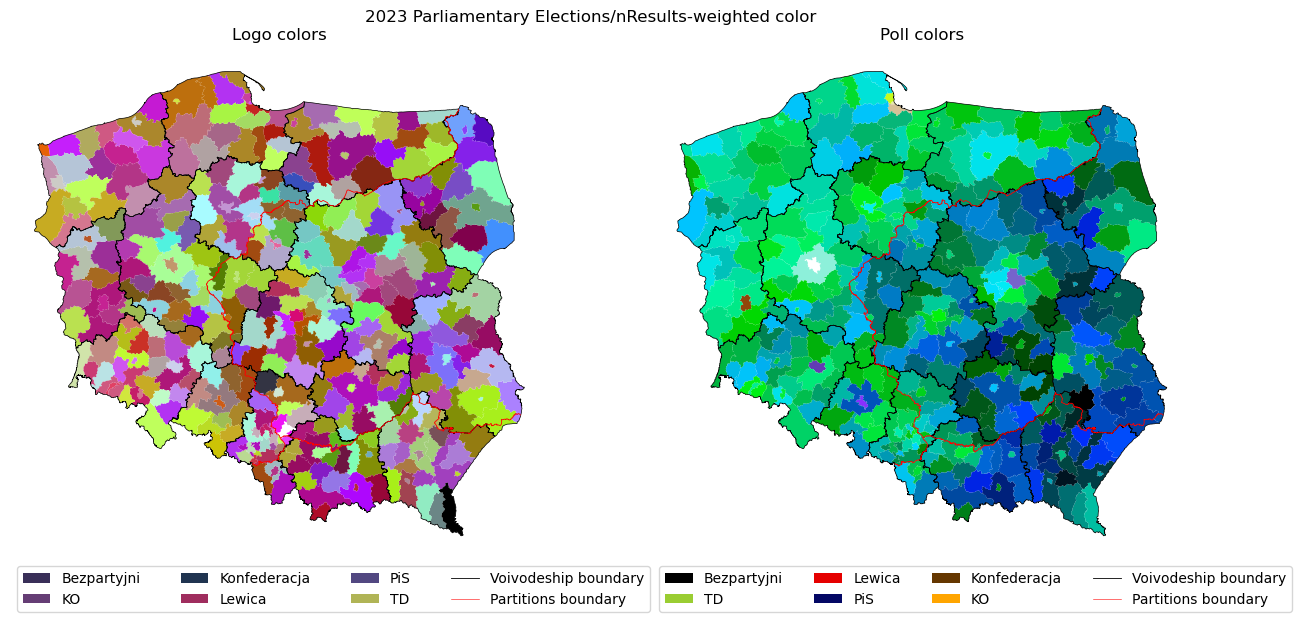

In [350]:
fig, ax = plt.subplots(1,2, figsize = (13,6))
fig.suptitle("2023 Parliamentary Elections/nResults-weighted color")
plt.tight_layout()

master_df.plot(
    column='weighted_color_total_logo', cmap=hex_converted_cmap, legend=False, ax=ax[0])
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax[0])
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.6, ax=ax[0])
ax[0].set_title("Logo colors")

master_df.plot(
    column='weighted_color_total_poll', cmap=hex_converted_cmap, legend=False, ax=ax[1])
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax[1])
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.6, ax=ax[1])
ax[1].set_title("Poll colors")
ax[0].axis('off')
ax[1].axis('off')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
customcolors1 = [Patch(facecolor="#"+val, lw=4, label=key) for key,val in colordict.items()]
customcolors1.extend([Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.4, color="red", label="Partitions boundary")])
customcolors2 = [Patch(facecolor="#"+val, lw=4, label=key) for key,val in colordict2.items()]
customcolors2.extend([Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.4, color="red", label="Partitions boundary")])
ax[0].legend(handles=customcolors1, bbox_to_anchor=(0, -.4, 1.2, 0.4), mode="expand", ncols=4)
ax[1].legend(handles=customcolors2, bbox_to_anchor=(0, -.4, 1.2, 0.4), mode="expand", ncols=4)

In [351]:
import matplotlib as mplt
balans_cnorm=mplt.colors.TwoSlopeNorm(vmin=master_df['_BALANS_'].min(), vcenter=0., vmax=master_df['_BALANS_'].max())
red = mplt.colors.rgb2hex(plt.get_cmap('coolwarm', 255)(0))
blue = mplt.colors.rgb2hex(plt.get_cmap('coolwarm', 255)(254))
balans_cmap=get_colormap(None, [red, 'ffffff', blue], "linear_multi_segmented")

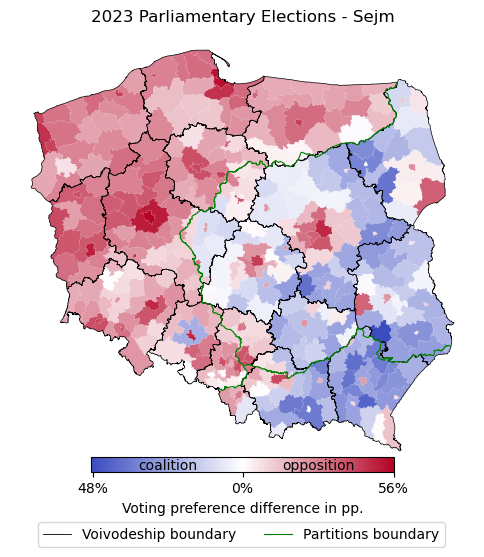

In [352]:
fig, ax = plt.subplots(1,1, figsize = (6,12))
master_df.plot(
    column='_BALANS_', norm=balans_cnorm, cmap=balans_cmap, legend=False, ax=ax)
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax)
zabory_df.plot(facecolor="none", edgecolor='green', lw=0.8, ax=ax)

ax.axis("off")
ax.set_title("2023 Parliamentary Elections - Sejm")

ax_cbar = fig.colorbar(plt.cm.ScalarMappable(norm=balans_cnorm, cmap=balans_cmap), location='bottom', pad=-.015, shrink=.65, ax=ax, label='Voting preference difference in pp.', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))
ax_cbar.set_ticks([int(master_df['_BALANS_'].min()), 0, master_df['_BALANS_'].max()])
ax_cbar.ax.text(-24, 0.45, 'coalition', ha='center', va='center')
ax_cbar.ax.text(28, 0.45, 'opposition', ha='center', va='center')


customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.8, color="green", label="Partitions boundary")]
ax.legend(handles=customcolors, bbox_to_anchor=(-.25, -.5, 1.2, 0.4), ncols = 2)

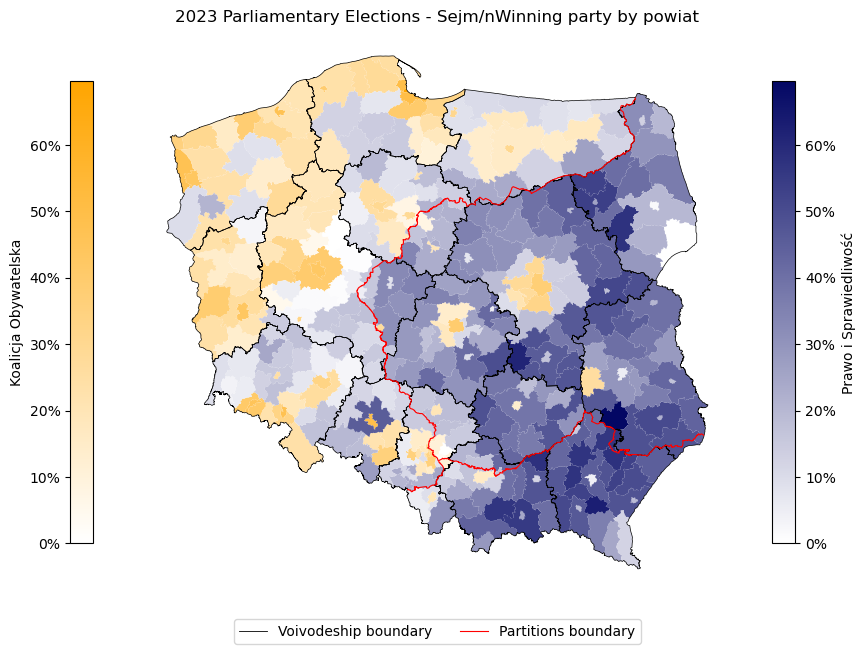

In [353]:
fig, ax = plt.subplots(1,1, figsize = (12,24))
master_df[master_df["max_partia"]=="KO"].plot(
    column='max_wynik', cmap=get_colormap(colordict2, "KO", 'linear_segmented'), legend=False, ax=ax)
master_df[master_df["max_partia"]=="PiS"].plot(
    column='max_wynik', cmap=get_colormap(colordict2, "PiS", 'linear_segmented'), legend=False, ax=ax)
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax)
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=ax)

max_wynik_scale = mplt.colors.Normalize(vmin=0, vmax=master_df['max_wynik'].max())
ax_cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm=max_wynik_scale, cmap=get_colormap(colordict2, "KO", 'linear_segmented')), location="left", pad=.05, shrink=.25, ax=ax, label='Koalicja Obywatelska', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))
ax_cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm=max_wynik_scale, cmap=get_colormap(colordict2, "PiS", 'linear_segmented')), location="right", shrink=.25, ax=ax, label='Prawo i Sprawiedliwość', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))

ax.axis("off")
ax.set_title("2023 Parliamentary Elections - Sejm/nWinning party by powiat")

customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.8, color="red", label="Partitions boundary")]
ax.legend(handles=customcolors, loc="lower center", bbox_to_anchor=(0.5, -.1), ncols = 2)

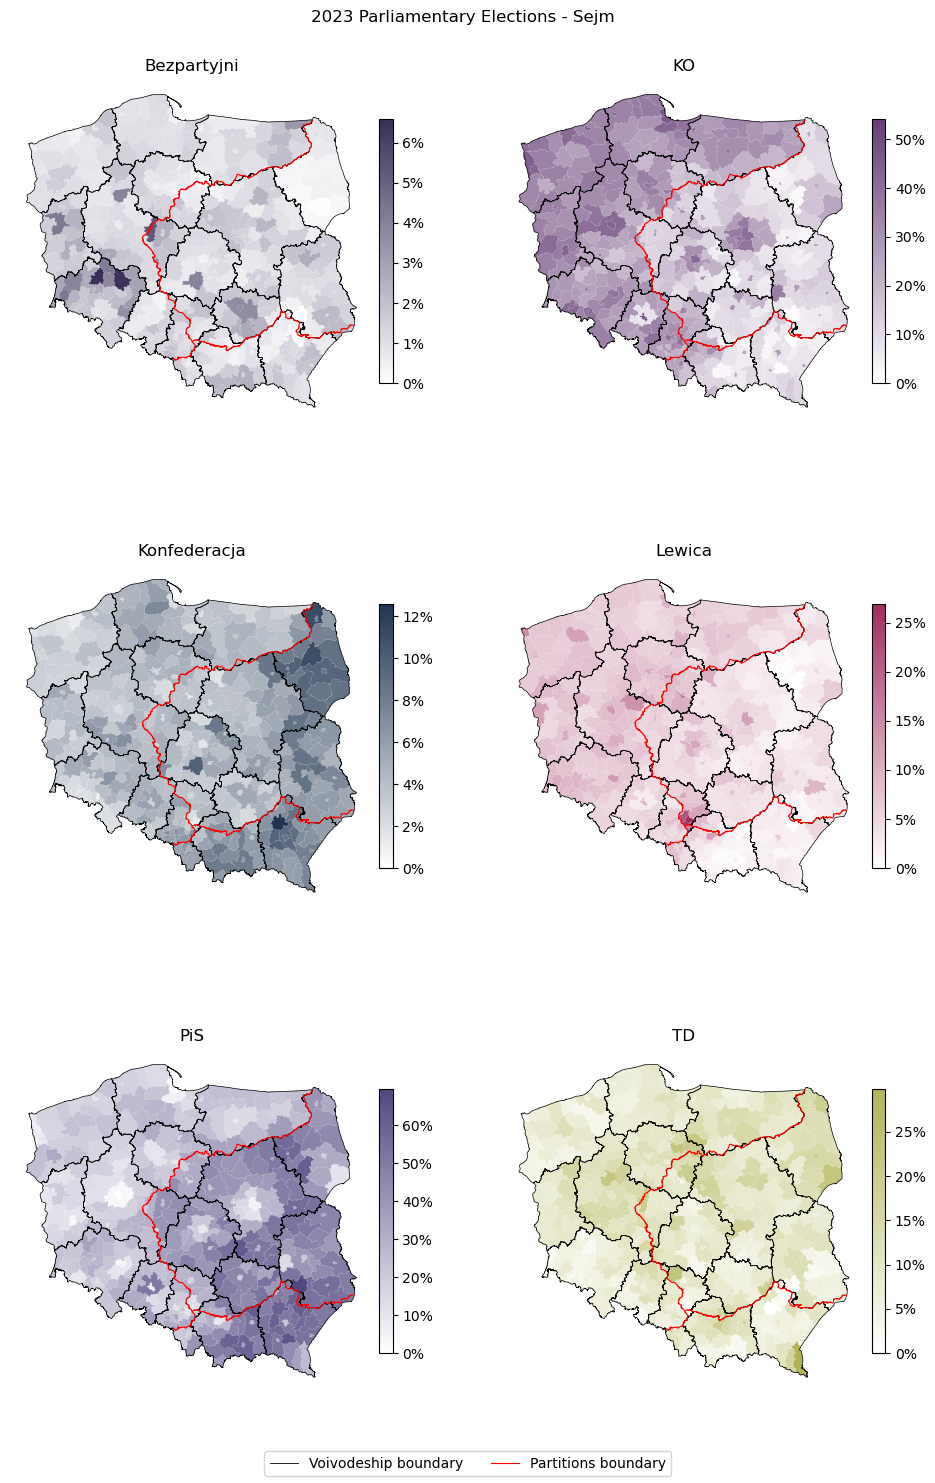

In [354]:
fig, axs = plt.subplots(3,2, figsize=(10,15))
fig.suptitle("2023 Parliamentary Elections - Sejm")
plt.tight_layout()
axs = axs.flatten()
for i, partia in enumerate(colordict.keys()):
    master_df.plot(
        column=partia, cmap=get_colormap(colordict, partia, 'linear_segmented'), legend=False, ax=axs[i])
    wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=axs[i])
    zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=axs[i])
    axs[i].axis("off")
    axs[i].set_title(f"{partia}")
    plt.colorbar(plt.cm.ScalarMappable(norm=mplt.colors.Normalize(vmin=0, vmax=master_df[partia].max()), cmap=get_colormap(colordict, partia, 'linear_segmented')), pad=.015, shrink=.6, ax=axs[i], format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x/100)))
customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.8, color="red", label="Partitions boundary")]
fig.legend(handles=customcolors, loc="lower center", ncols = 2)

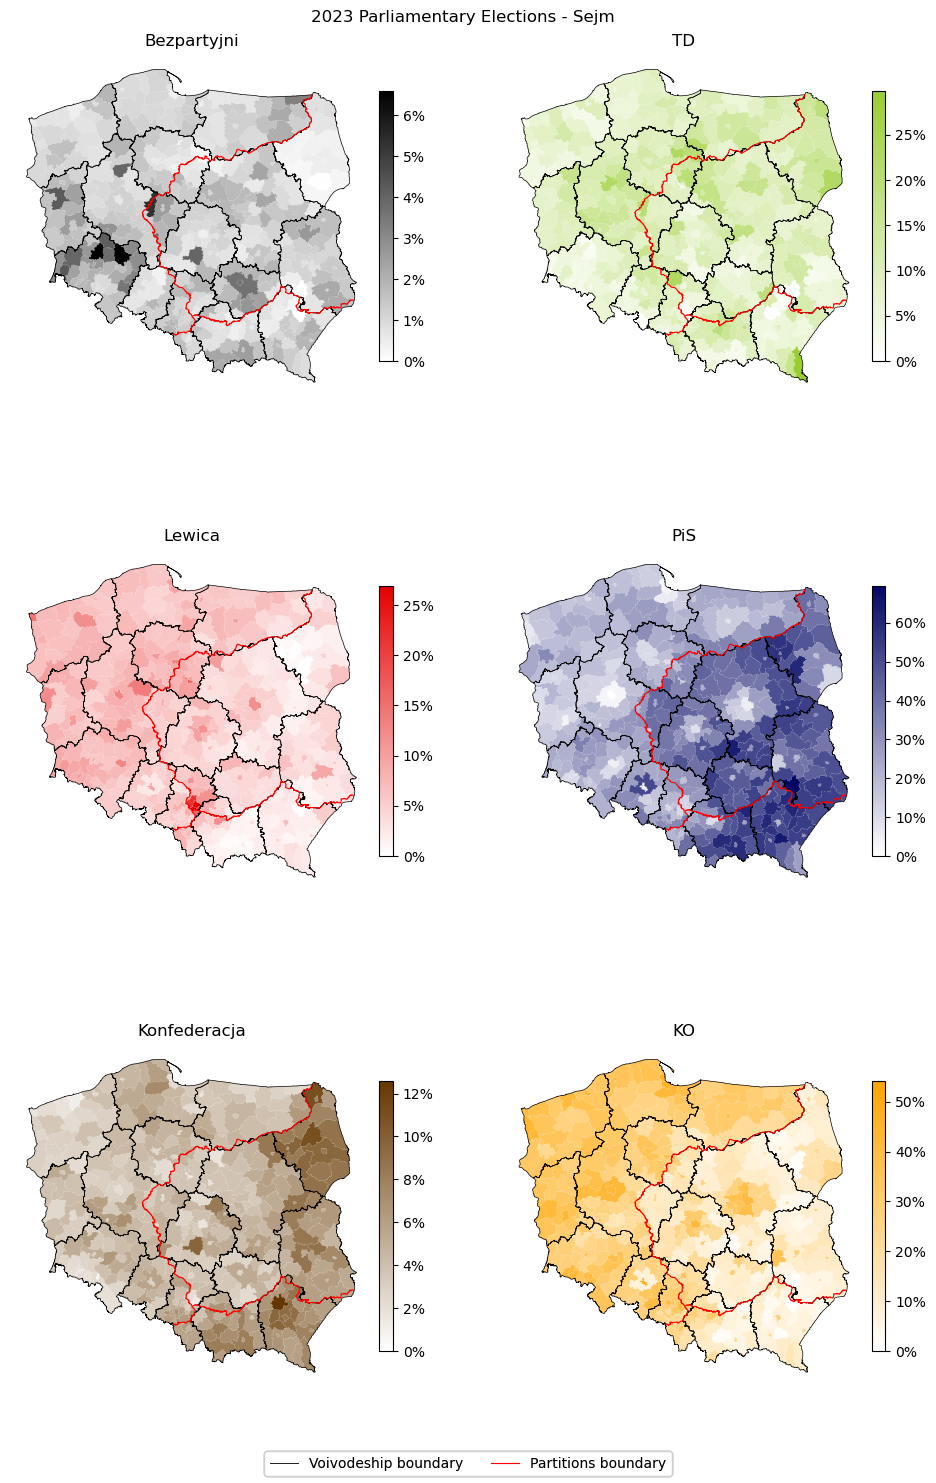

In [355]:
fig, axs = plt.subplots(3,2, figsize=(10,15))
plt.tight_layout()
fig.suptitle("2023 Parliamentary Elections - Sejm")
axs = axs.flatten()
for i, partia in enumerate(colordict2.keys()):
    master_df.plot(
        column=partia, cmap=get_colormap(colordict2, partia, 'linear_segmented'), legend=False, ax=axs[i])
    wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=axs[i])
    zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=axs[i])
    axs[i].axis("off")
    axs[i].set_title(f"{partia}")
    plt.colorbar(plt.cm.ScalarMappable(norm=mplt.colors.Normalize(vmin=0, vmax=master_df[partia].max()), cmap=get_colormap(colordict2, partia, 'linear_segmented')), pad=.015, shrink=.6, ax=axs[i], format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x/100)))
    fig.legend(handles=customcolors, loc="lower center", ncols = 2)

In [358]:
import matplotlib as mplt
sila_cnorm=mplt.colors.TwoSlopeNorm(vmin=okregi_master_df['sila glosu'].min(), vcenter=100, vmax=okregi_master_df['sila glosu'].max())

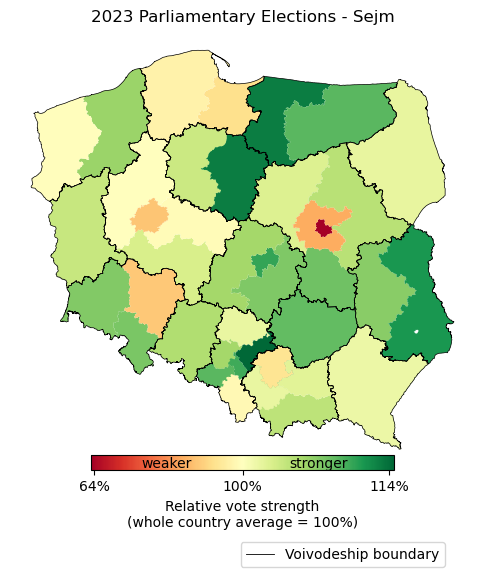

In [359]:
fig, ax = plt.subplots(1,1, figsize = (6,12))
okregi_master_df.plot(column='sila glosu', cmap='RdYlGn', norm=sila_cnorm, legend=False, ax=ax)
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax)

ax.axis("off")
ax.set_title("2023 Parliamentary Elections - Sejm")

ax_cbar = fig.colorbar(plt.cm.ScalarMappable(norm=sila_cnorm, cmap='RdYlGn'), location='bottom',
                       pad=-.015, shrink=.65, ax=ax, label='Relative vote strength\n(whole country average = 100%)', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))
ax_cbar.set_ticks([int(okregi_master_df['sila glosu'].min())+1, 100., int(okregi_master_df['sila glosu'].max())])
ax_cbar.ax.text(okregi_master_df['sila glosu'].min()+(100-okregi_master_df['sila glosu'].min())/2, 0.45, 'weaker', ha='center', va='center')
ax_cbar.ax.text(100+(okregi_master_df['sila glosu'].max()-100)/2, 0.45, 'stronger', ha='center', va='center')


customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary")]
ax.legend(handles=customcolors, bbox_to_anchor=(-.25, -.55, 1.2, 0.4))

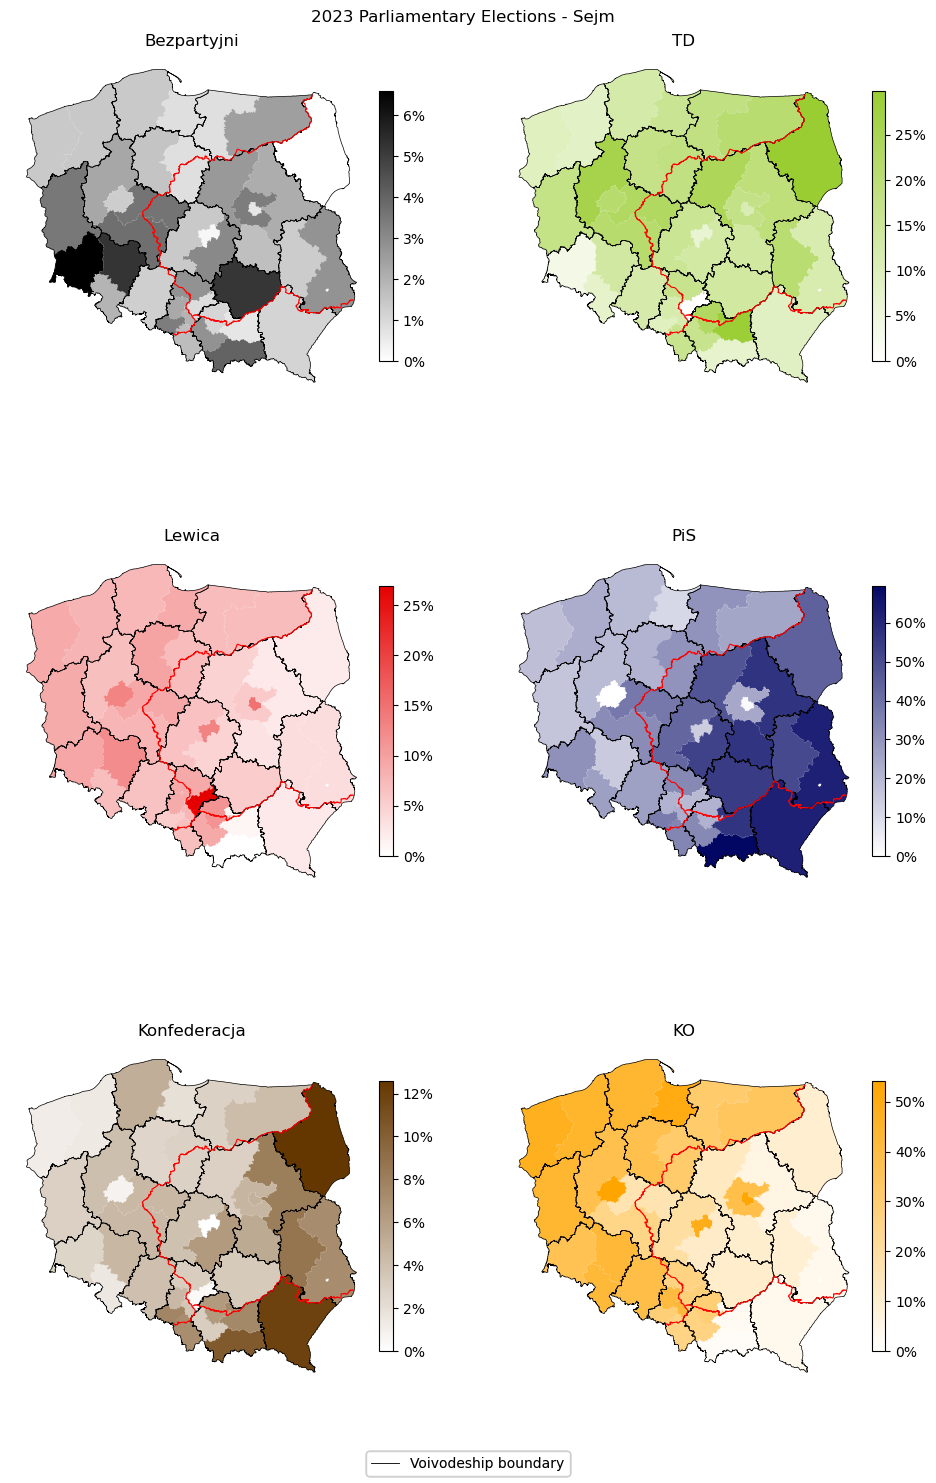

In [360]:
fig, axs = plt.subplots(3,2, figsize=(10,15))
plt.tight_layout()
fig.suptitle("2023 Parliamentary Elections - Sejm")
axs = axs.flatten()
for i, partia in enumerate(colordict2.keys()):
    okregi_master_df.plot(
        column=partia, cmap=get_colormap(colordict2, partia, 'linear_segmented'), legend=False, ax=axs[i])
    wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=axs[i])
    zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=axs[i])
    axs[i].axis("off")
    axs[i].set_title(f"{partia}")
    plt.colorbar(plt.cm.ScalarMappable(norm=mplt.colors.Normalize(vmin=0, vmax=master_df[partia].max()), cmap=get_colormap(colordict2, partia, 'linear_segmented')), pad=.015, shrink=.6, ax=axs[i], format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x/100)))
    fig.legend(handles=customcolors, loc="lower center", ncols = 2)

In [361]:
okregi_master_df2 = pd.DataFrame(okregi_master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]])
okregi_master_df['max_wynik']=okregi_master_df2.max(axis=1)
okregi_master_df['max_partia']=okregi_master_df2.idxmax(axis=1)

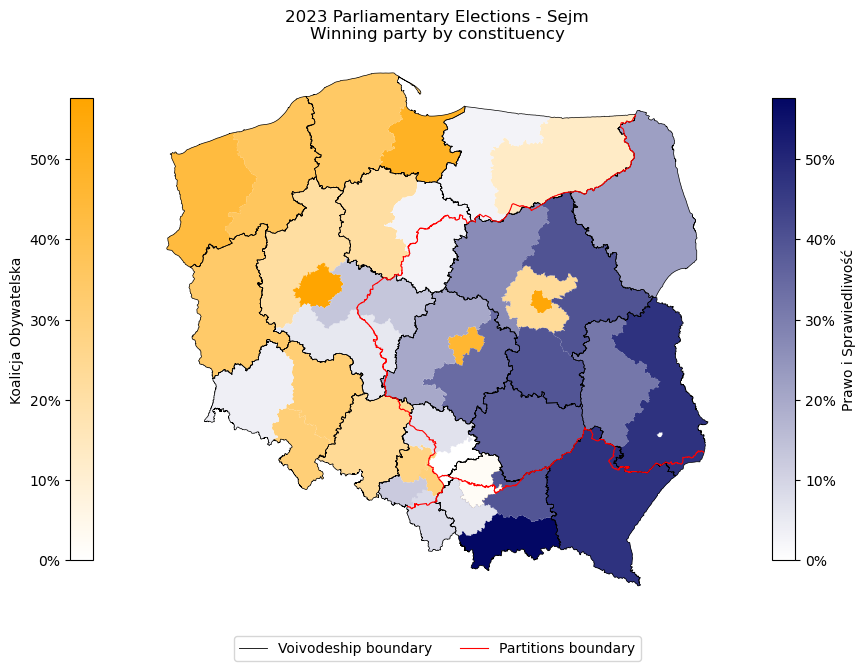

In [362]:
fig, ax = plt.subplots(1,1, figsize = (12,24))
okregi_master_df[okregi_master_df["max_partia"]=="KO"].plot(
    column='max_wynik', cmap=get_colormap(colordict2, "KO", 'linear_segmented'), legend=False, ax=ax)
okregi_master_df[okregi_master_df["max_partia"]=="PiS"].plot(
    column='max_wynik', cmap=get_colormap(colordict2, "PiS", 'linear_segmented'), legend=False, ax=ax)
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax)
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=ax)

max_wynik_scale = mplt.colors.Normalize(vmin=0, vmax=okregi_master_df['max_wynik'].max())
ax_cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm=max_wynik_scale, cmap=get_colormap(colordict2, "KO", 'linear_segmented')), location="left", pad=.05, shrink=.25, ax=ax, label='Koalicja Obywatelska', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))
ax_cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm=max_wynik_scale, cmap=get_colormap(colordict2, "PiS", 'linear_segmented')), location="right", shrink=.25, ax=ax, label='Prawo i Sprawiedliwość', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))

ax.axis("off")
ax.set_title("2023 Parliamentary Elections - Sejm\nWinning party by constituency")

customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.8, color="red", label="Partitions boundary")]
ax.legend(handles=customcolors, loc="lower center", bbox_to_anchor=(0.5, -.1), ncols = 2)

In [363]:
weights_o = okregi_master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].values
colors = [colordict[name] for name in master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].columns]
colors2 = [colordict2[name] for name in master_df[["Bezpartyjni",	"TD",	"Lewica",	"PiS",	"Konfederacja",	"KO"]].columns]
okregi_master_df['weighted_color_total_logo'] = get_weighted_color_value(colors=colors, weights=weights_o)
okregi_master_df['weighted_color_total_poll'] = get_weighted_color_value(colors=colors2, weights=weights_o)

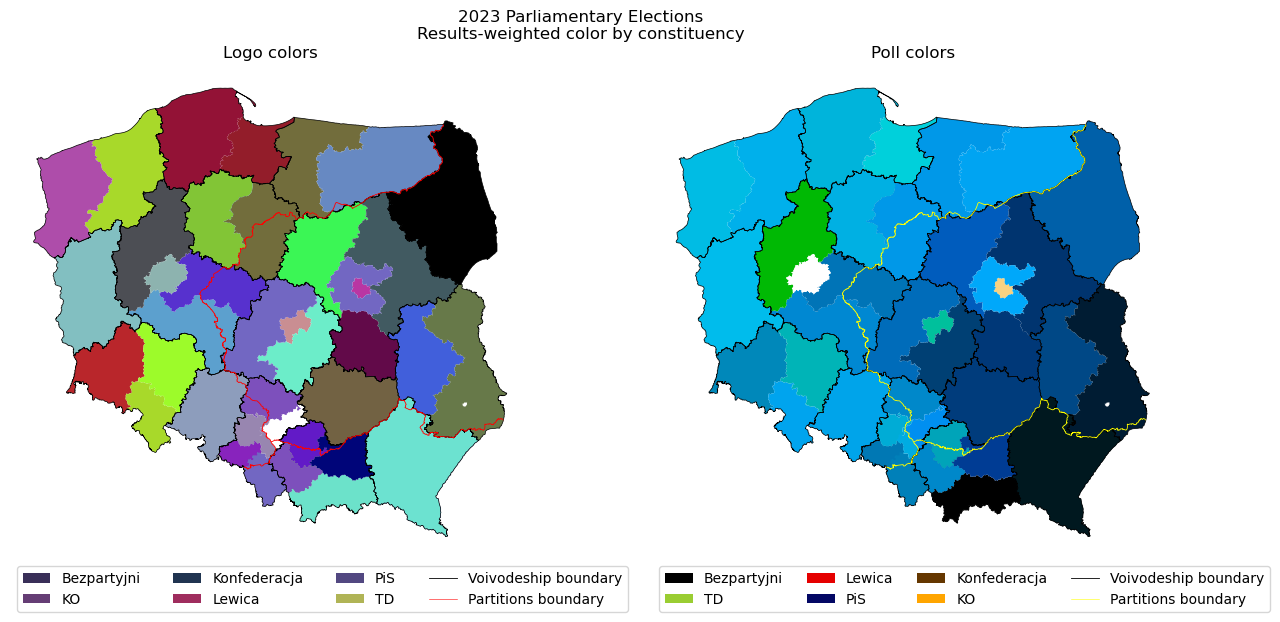

In [364]:
fig, ax = plt.subplots(1,2, figsize = (13,6))
fig.suptitle("2023 Parliamentary Elections\nResults-weighted color by constituency")
plt.tight_layout()

okregi_master_df.plot(
    column='weighted_color_total_logo', cmap=hex_converted_cmap, legend=False, ax=ax[0])
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax[0])
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.6, ax=ax[0])
ax[0].set_title("Logo colors")

okregi_master_df.plot(
    column='weighted_color_total_poll', cmap=hex_converted_cmap, legend=False, ax=ax[1])
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax[1])
zabory_df.plot(facecolor="none", edgecolor='yellow', lw=0.6, ax=ax[1])
ax[1].set_title("Poll colors")
ax[0].axis('off')
ax[1].axis('off')

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
customcolors1 = [Patch(facecolor="#"+val, lw=4, label=key) for key,val in colordict.items()]
customcolors1.extend([Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.4, color="red", label="Partitions boundary")])
customcolors2 = [Patch(facecolor="#"+val, lw=4, label=key) for key,val in colordict2.items()]
customcolors2.extend([Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.4, color="yellow", label="Partitions boundary")])
ax[0].legend(handles=customcolors1, bbox_to_anchor=(0, -.4, 1.2, 0.4), mode="expand", ncols=4)
ax[1].legend(handles=customcolors2, bbox_to_anchor=(0, -.4, 1.2, 0.4), mode="expand", ncols=4)

In [365]:
def parse_senat_okregi_wyniki(master_df):
    populacja_senat = master_df.groupby('okręg Senat')['populacja'].sum()
    populacja_senat['33'] = 335674
    populacja_senat['32'] = 366979
    populacja_senat['42'], populacja_senat['43'], populacja_senat['44'], populacja_senat['45'] = 422979, 514919,447190,477968
    populacja_senat['23'] = populacja_senat['Łódź']/2
    populacja_senat['24'] = populacja_senat['24'] + populacja_senat['Łódź']/2
    populacja_senat['7'], populacja_senat['8'] = populacja_senat['Wrocław']/2, populacja_senat['Wrocław']/2
    populacja_correction = populacja_senat['12']
    populacja_senat['121'] = populacja_senat['12']
    populacja_senat['122'] = populacja_senat['12']

    senat_df = gpd.GeoDataFrame(populacja_senat)
    senat_df.drop(['Warszawa', 'Kraków', 'Łódź', 'Wrocław', '12'], inplace=True)
    senat_df.sort_index(inplace=True)
    senat_df.index = senat_df.index.astype(int)
    senat_df['siła głosu'] = 100*(1/senat_df['populacja'])/(100/(sum(senat_df['populacja'])-populacja_correction))
    return senat_df

In [366]:
def parse_senat_geo(senat_geo_csv: Union[Path, str]):
    senat_geo = gpd.read_file(senat_geo_csv)
    senat_geo.set_index("fid", inplace=True)
    senat_geo.index.astype(int)
    senat_geo = senat_geo[['id','geometry']]

    return senat_geo

In [367]:
senat_geo_csv = "C:/Users/freyf/OneDrive/Pulpit/Filip/inne/wybory 2023/Senat_okregi2.geojson"
senat_df_master = gpd.GeoDataFrame(pd.concat([parse_senat_okregi_wyniki(master_df=master_df), parse_senat_geo(senat_geo_csv=senat_geo_csv)], axis=1))

In [368]:
import matplotlib as mplt
sila_cnorm_senat=mplt.colors.TwoSlopeNorm(vmin=senat_df_master['siła głosu'].min(), vcenter=100, vmax=senat_df_master['siła głosu'].max())

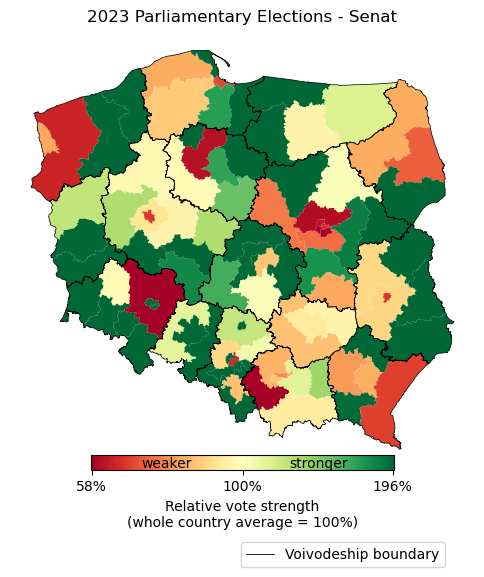

In [369]:
fig, ax = plt.subplots(1,1, figsize = (6,12))
senat_df_master.plot(column='siła głosu', cmap='RdYlGn', norm=sila_cnorm, legend=False, ax=ax)
wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=ax)

ax.axis("off")
ax.set_title("2023 Parliamentary Elections - Senat")

ax_cbar = fig.colorbar(plt.cm.ScalarMappable(norm=sila_cnorm_senat, cmap='RdYlGn'), location='bottom',
                       pad=-.015, shrink=.65, ax=ax, label='Relative vote strength\n(whole country average = 100%)', format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(abs(x)/100)))
ax_cbar.set_ticks([int(senat_df_master['siła głosu'].min())+1, 100., int(senat_df_master['siła głosu'].max())])
ax_cbar.ax.text(senat_df_master['siła głosu'].min()+(100-senat_df_master['siła głosu'].min())/2, 0.45, 'weaker', ha='center', va='center')
ax_cbar.ax.text(100+(senat_df_master['siła głosu'].max()-100)/2, 0.45, 'stronger', ha='center', va='center')


customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary")]
ax.legend(handles=customcolors, bbox_to_anchor=(-.25, -.55, 1.2, 0.4))

In [370]:
PiS_avg, KO_avg, TD_avg, Lewica_avg, Konfederacja_avg, Bezpartyjni_avg = 35.38, 30.7, 14.4, 8.61, 7.16, 1.86
for partia in colordict.keys():
    avg = globals()[f"{partia}_avg"]
    master_df[f"{partia}_DIFF"] = master_df[f"{partia}"]-avg

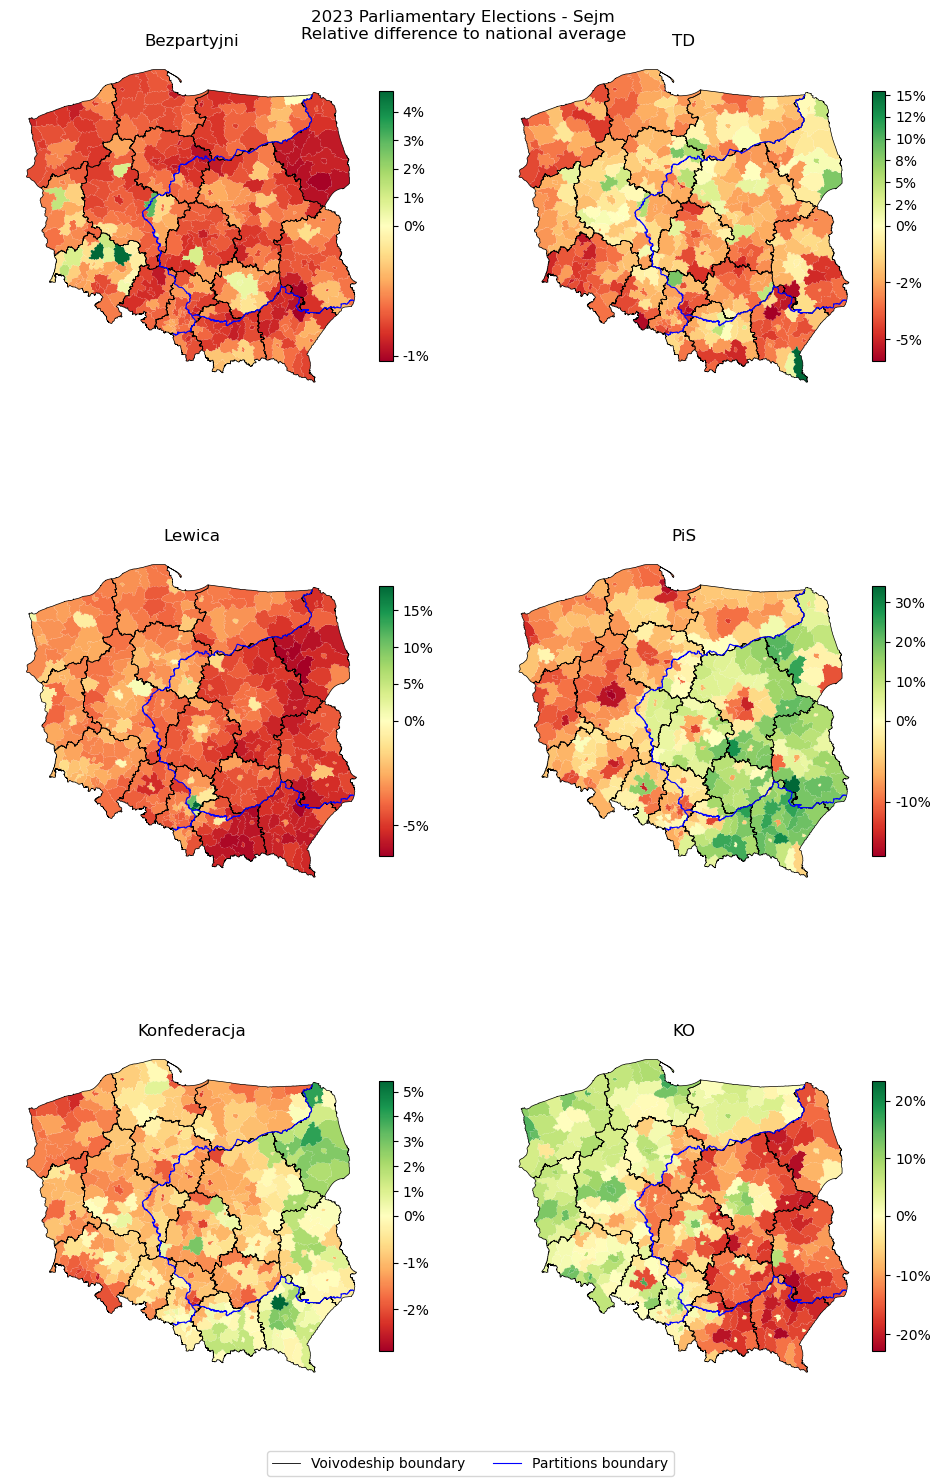

In [371]:
customcolors = [Line2D([0], [0], lw=.6, color="black", label="Voivodeship boundary"), Line2D([0], [0], lw=.8, color="blue", label="Partitions boundary")]
fig, axs = plt.subplots(3,2, figsize=(10,15), layout="tight")
plt.tight_layout()
fig.suptitle("2023 Parliamentary Elections - Sejm\nRelative difference to national average")
axs = axs.flatten()
for i, partia in enumerate(colordict2.keys()):
    sila_cnorm_partia=mplt.colors.TwoSlopeNorm(vmin=master_df[f"{partia}_DIFF"].min(), vcenter=0, vmax=master_df[f"{partia}_DIFF"].max())
    
    master_df.plot(
        column=f"{partia}_DIFF", cmap='RdYlGn', legend=False, ax=axs[i])
    wojewodztwa_df.plot(facecolor="none", edgecolor='black', lw=0.5, ax=axs[i])
    zabory_df.plot(facecolor="none", edgecolor='blue', lw=0.8, ax=axs[i])
    axs[i].axis("off")
    axs[i].set_title(f"{partia}")
    plt.colorbar(plt.cm.ScalarMappable(norm=sila_cnorm_partia, cmap="RdYlGn"), pad=.015, shrink=.6, ax=axs[i], format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x/100)))

fig.legend(handles=customcolors, loc="lower center", ncols = 2)

In [372]:
master_df['reprezentatywność_RMSE'] = np.sqrt(sum([np.power(master_df[column],2) for column in master_df.columns if "_DIFF" in column])/6)
master_df['reprezentatywność_MAE'] = sum([abs(master_df[column]) for column in master_df.columns if "_DIFF" in column])/6

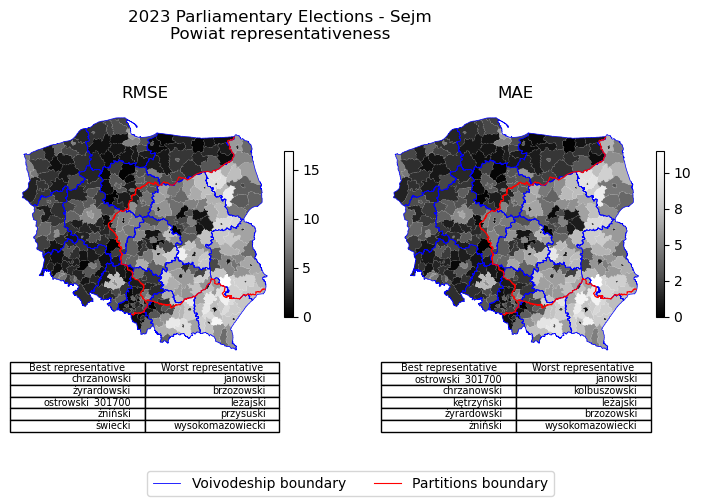

In [430]:
fig, axs = plt.subplots(1,2, figsize=(9,5))

fig.suptitle("2023 Parliamentary Elections - Sejm\nPowiat representativeness")
plt.tight_layout()
axs = axs.flatten()
master_df.plot(
        column="reprezentatywność_RMSE", cmap="Greys_r", legend=False, ax=axs[0])
master_df.plot(
        column="reprezentatywność_MAE", cmap="Greys_r", legend=False, ax=axs[1])

wojewodztwa_df.plot(facecolor="none", edgecolor='blue', lw=0.5, ax=axs[0])
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=axs[0])
wojewodztwa_df.plot(facecolor="none", edgecolor='blue', lw=0.5, ax=axs[1])
zabory_df.plot(facecolor="none", edgecolor='red', lw=0.8, ax=axs[1])

axs[0].axis("off")
axs[0].set_title("RMSE")
axs[1].axis("off")
axs[1].set_title("MAE")

ct = [[master_df.nsmallest(5, 'reprezentatywność_RMSE').index[i], master_df.nlargest(5, 'reprezentatywność_RMSE').index[i]] for i in range(5)]
the_table = axs[0].table(cellText=ct,
                      colLabels=["Best representative", "Worst representative"],
                      loc='bottom')

ct = [[master_df.nsmallest(5, 'reprezentatywność_MAE').index[i], master_df.nlargest(5, 'reprezentatywność_MAE').index[i]] for i in range(5)]
the_table = axs[1].table(cellText=ct,
                      colLabels=["Best representative", "Worst representative"],
                      loc='bottom')

plt.subplots_adjust(left=0.2, bottom=0.2)
plt.colorbar(plt.cm.ScalarMappable(norm=mplt.colors.Normalize(vmin=0, vmax=master_df["reprezentatywność_RMSE"].max()), cmap='Greys_r'), pad=.015, shrink=.5, ax=axs[0], format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0f}".format(x)))
plt.colorbar(plt.cm.ScalarMappable(norm=mplt.colors.Normalize(vmin=0, vmax=master_df["reprezentatywność_MAE"].max()), cmap='Greys_r'), pad=.015, shrink=.5, ax=axs[1], format=mplt.ticker.FuncFormatter(lambda x, pos: "{:.0f}".format(x)))

customcolors = [Line2D([0], [0], lw=.6, color="blue", label="Voivodeship boundary"), Line2D([0], [0], lw=.8, color="red", label="Partitions boundary")]
fig.legend(handles=customcolors, loc="lower center", ncols = 2)